In [1]:
from unsampled import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats.stats import pearsonr
import scipy.stats as stats
from colour import Color

## Tree Visualizations

### Setting up the Trees and Plotting

In [2]:
t1 = Tree.get(path="tree1", schema="nexus")

In [3]:
rd.seed(100) #for replicability
pruned_dict = randomly_prune_tree(t1, .95)
popsize = 1

#matrix of observed and expected attachemt to each edge in the pruned tree for each dropped sample
exp = theoretical_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('root_reference'), 
                                   popsize, pruned_dict.get('node_root_dist_full_tree'), pruned_dict.get('dropped_samples'))
obs = observed_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('dropped_samples'))

In [4]:
#y-plotting for the full tree
y_positions = y_dist_dict(t1)
node_probs = calculate_cumulative_node_prob(t1, 1)

#y-plotting for the pruned tree
y_pos = y_dist_dict(pruned_dict.get('pruned_tree'))

In [5]:
#create the list of node labels that correspond to the pruned tree in the full tree
tips_left = [node for node in pruned_dict.get('pruned_tree').leaf_nodes()]
pruned_labs = [node.label for node in tips_left]
for sample in tips_left:
    curr = next(n for n in pruned_dict.get('full_tree').nodes() if n.label == sample.label)
    while curr.label != pruned_dict.get('pruned_tree').seed_node.label:
        pruned_labs.append(curr.label)
        curr = curr.parent_node
pruned_labs.append(pruned_dict.get('pruned_tree').seed_node.label)        
pruned_labs = list(set(pruned_labs))

#dictionary of the number of times each remaining edge has a missing branch
pruned_tree_labs = [node.label for node in pruned_dict.get('pruned_tree').nodes()]
true_num_unsamp = {}
obs = observed_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('dropped_samples'))
for nd_row in obs:
    obs_index = list(nd_row).index(1)
    if pruned_tree_labs[obs_index] in true_num_unsamp.keys():
        true_num_unsamp[pruned_tree_labs[obs_index]] += 1
    else:
        true_num_unsamp[pruned_tree_labs[obs_index]] = 1

In [6]:
#dictionary of the number of times each remaining edge has a missing branch
pruned_tree_labs = [node.label for node in pruned_dict.get('pruned_tree').nodes()]
true_num_unsamp = dict([(lab, 0) for lab in pruned_tree_labs])

obs = observed_attachment_prob_matrix(pruned_dict.get('full_tree'), pruned_dict.get('pruned_tree'), pruned_dict.get('dropped_samples'))
for nd_row in obs:
    obs_index = list(nd_row).index(1)
    true_num_unsamp[pruned_tree_labs[obs_index]] += 1

### Full Tree with Missing Samples

In [7]:
#defaults across all plots
rt_len = .1
alpha_scale_factor = 87.1
y_ax = len(pruned_dict.get('pruned_tree').leaf_nodes())
#colors
cmap = mpl.cm.get_cmap('inferno') #color map for gradients
unsamp = '#ea8281' #plotting unsampled branches color
samp = '#020360' #plotting sampled branches
col3 = '#c10100' #expected v observed proportions
col4 = '#c10100'#scatter, not w/in 2.5 - 97.5th percentile
col5 = '#90c6e4'#scatter, w/in percentile range
#default line type, point size, branch width
lty = '-'
s = 50
branchWidth=2

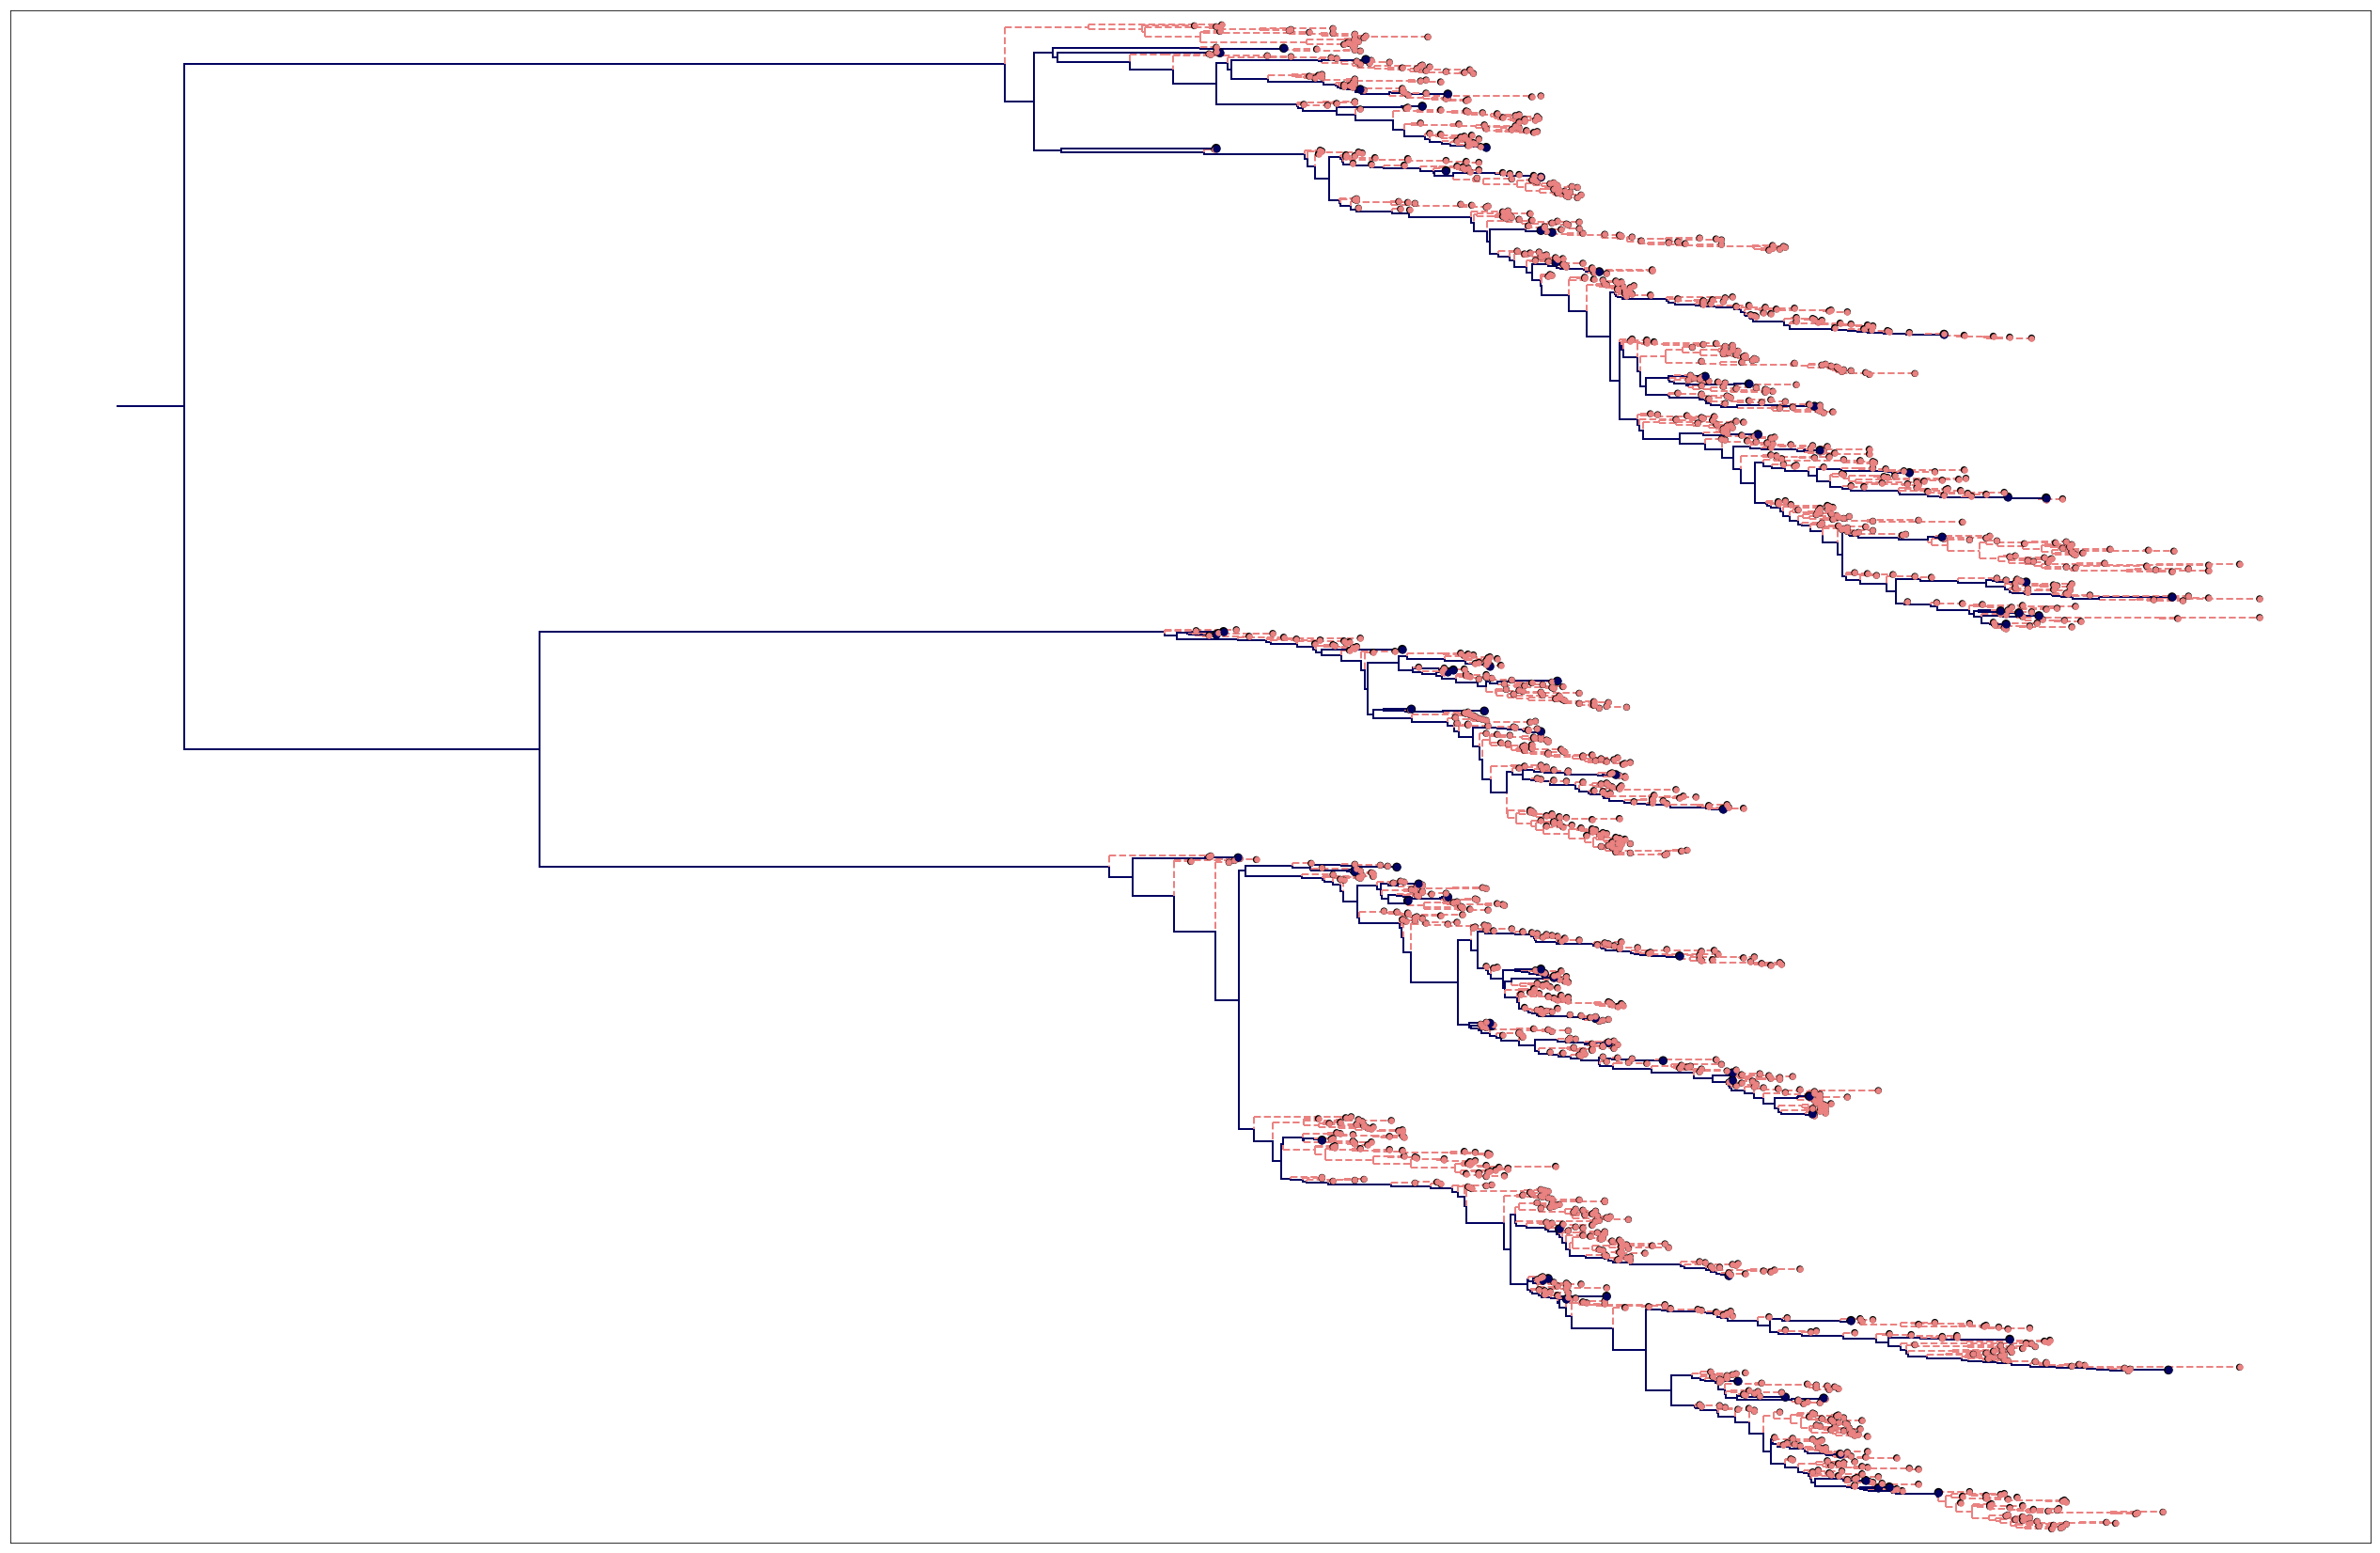

In [8]:
#plotted missing samples
fig,ax = plt.subplots(figsize=(45,30),facecolor='w')

for k in pruned_dict.get('full_tree').nodes(): # iterate over objects in full tree
    # positioning
    y=y_positions.get(k) 
    yp = y_positions.get(k.parent_node)
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()
    if k.parent_node==None:
        xp=x-rt_len #draw a root of length (arbitrary)
    else:
        xp=k.parent_node.distance_from_root()

    # dropped tips, color, lty, size
    c = [unsamp if k.label not in pruned_labs else samp][0]
    l = ['--' if k.label not in pruned_labs else '-'][0]
    sz = [30 if k.label not in pruned_labs else 50][0]
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=sz,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=sz+0.8*sz,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=c,ls=l, zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=c, ls=l, zorder=9) #branch plotting
       
ax.set_ylim(-15, len(pruned_dict.get('full_tree').leaf_nodes()) + 15)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()

### Pruned Tree Labeled with Observed Missing Samples on Each Branch

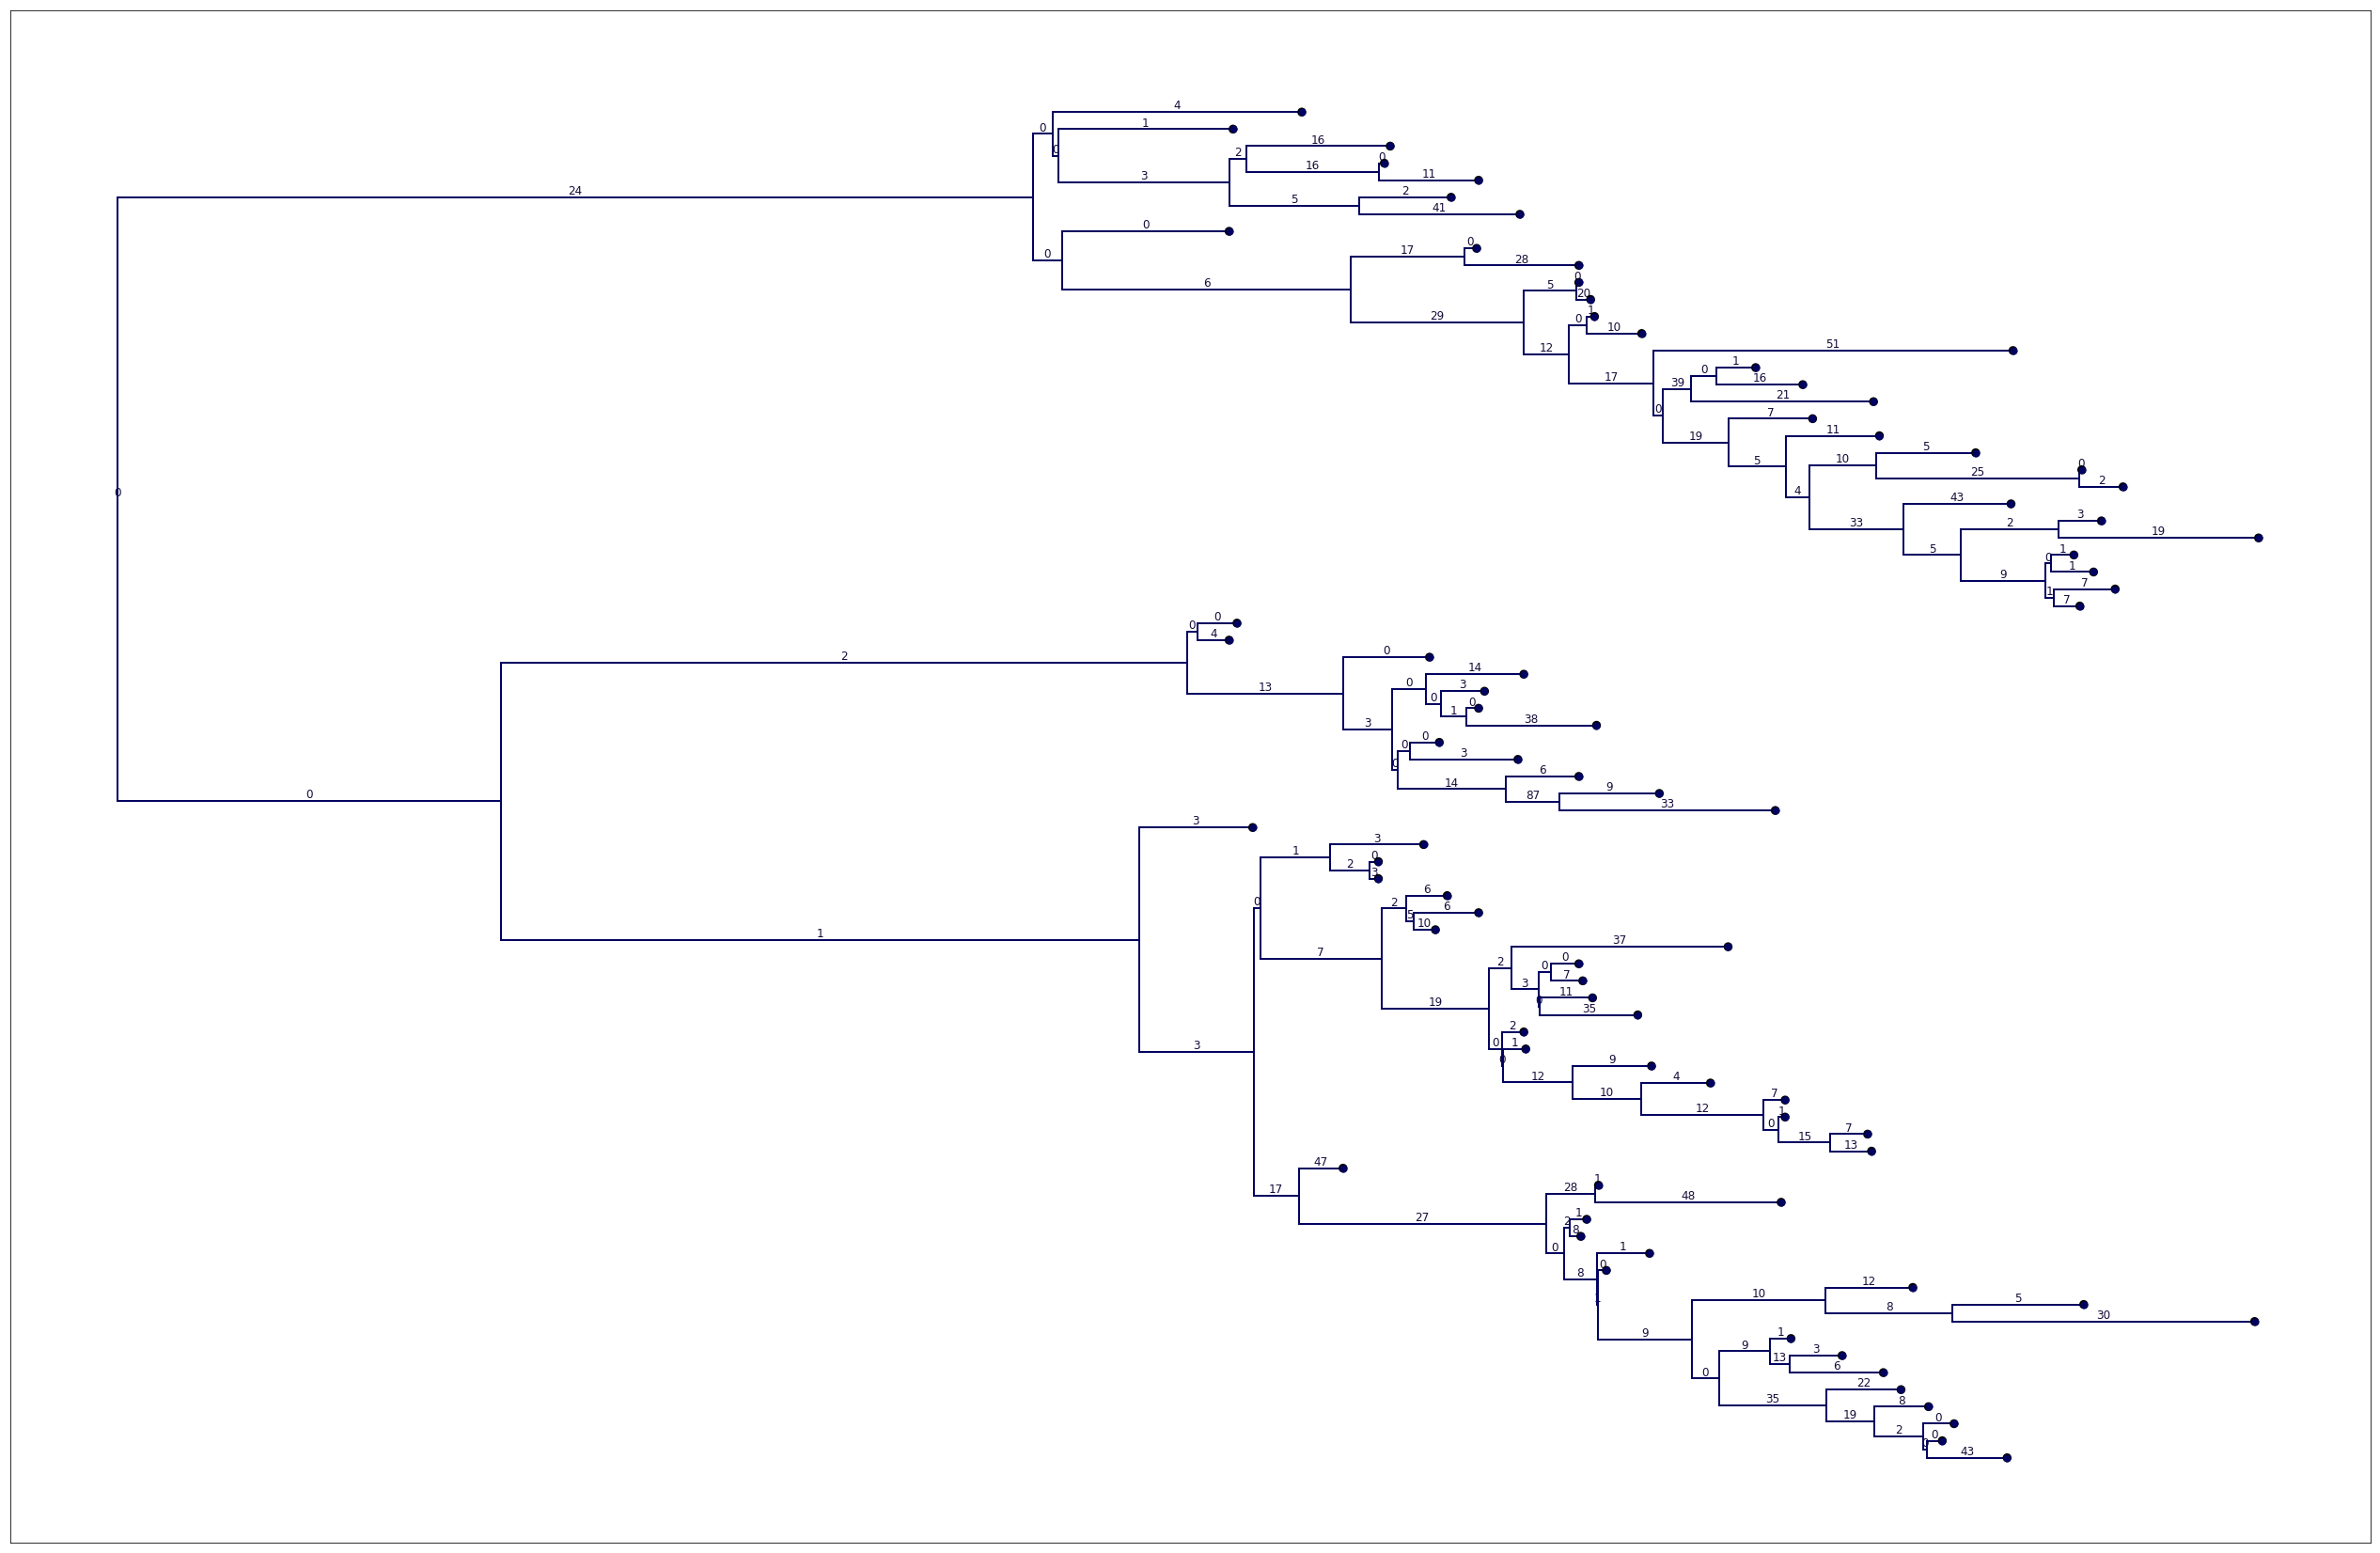

In [9]:
#plotted missing samples
fig,ax = plt.subplots(figsize=(45,30),facecolor='w')

for k in pruned_dict.get('pruned_tree').nodes(): # iterate over objects in tree
    
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x
        yp = y_pos.get(k)
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
        
    #distribution of missing samples
    if true_num_unsamp.has_key(k.label):
        dropped = true_num_unsamp.get(k.label)
    else:
        dropped = 0

    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=samp,edgecolor=samp,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
        
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=samp,ls=lty,zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=samp, ls=lty, zorder=9) #branch plotting
    
    #labeling number of true missing branches along each edge
    ax.text(x-.5*(x-xp) , y, dropped, va='bottom', ha='center', size=12, color = cmap(.1)) 
       
ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

### Pruned Tree with Distribution of Expected and Observed Missing Samples

Plots the pruned tree with the distribution of emperically observed and expected missing sampled. The opacity of the rectangle above each branch represents the raw number of expected observations predicted by the algorithm (expected proportion multiplied by the number of missing samples). The opacity of the rectangle below each branch represents the actual number of samples missing from that branch. When the difference between the observed and expected differs by more than 1% of the total dropped branches, the actual counts of predicted and observed are labeled by the respective rectangle.

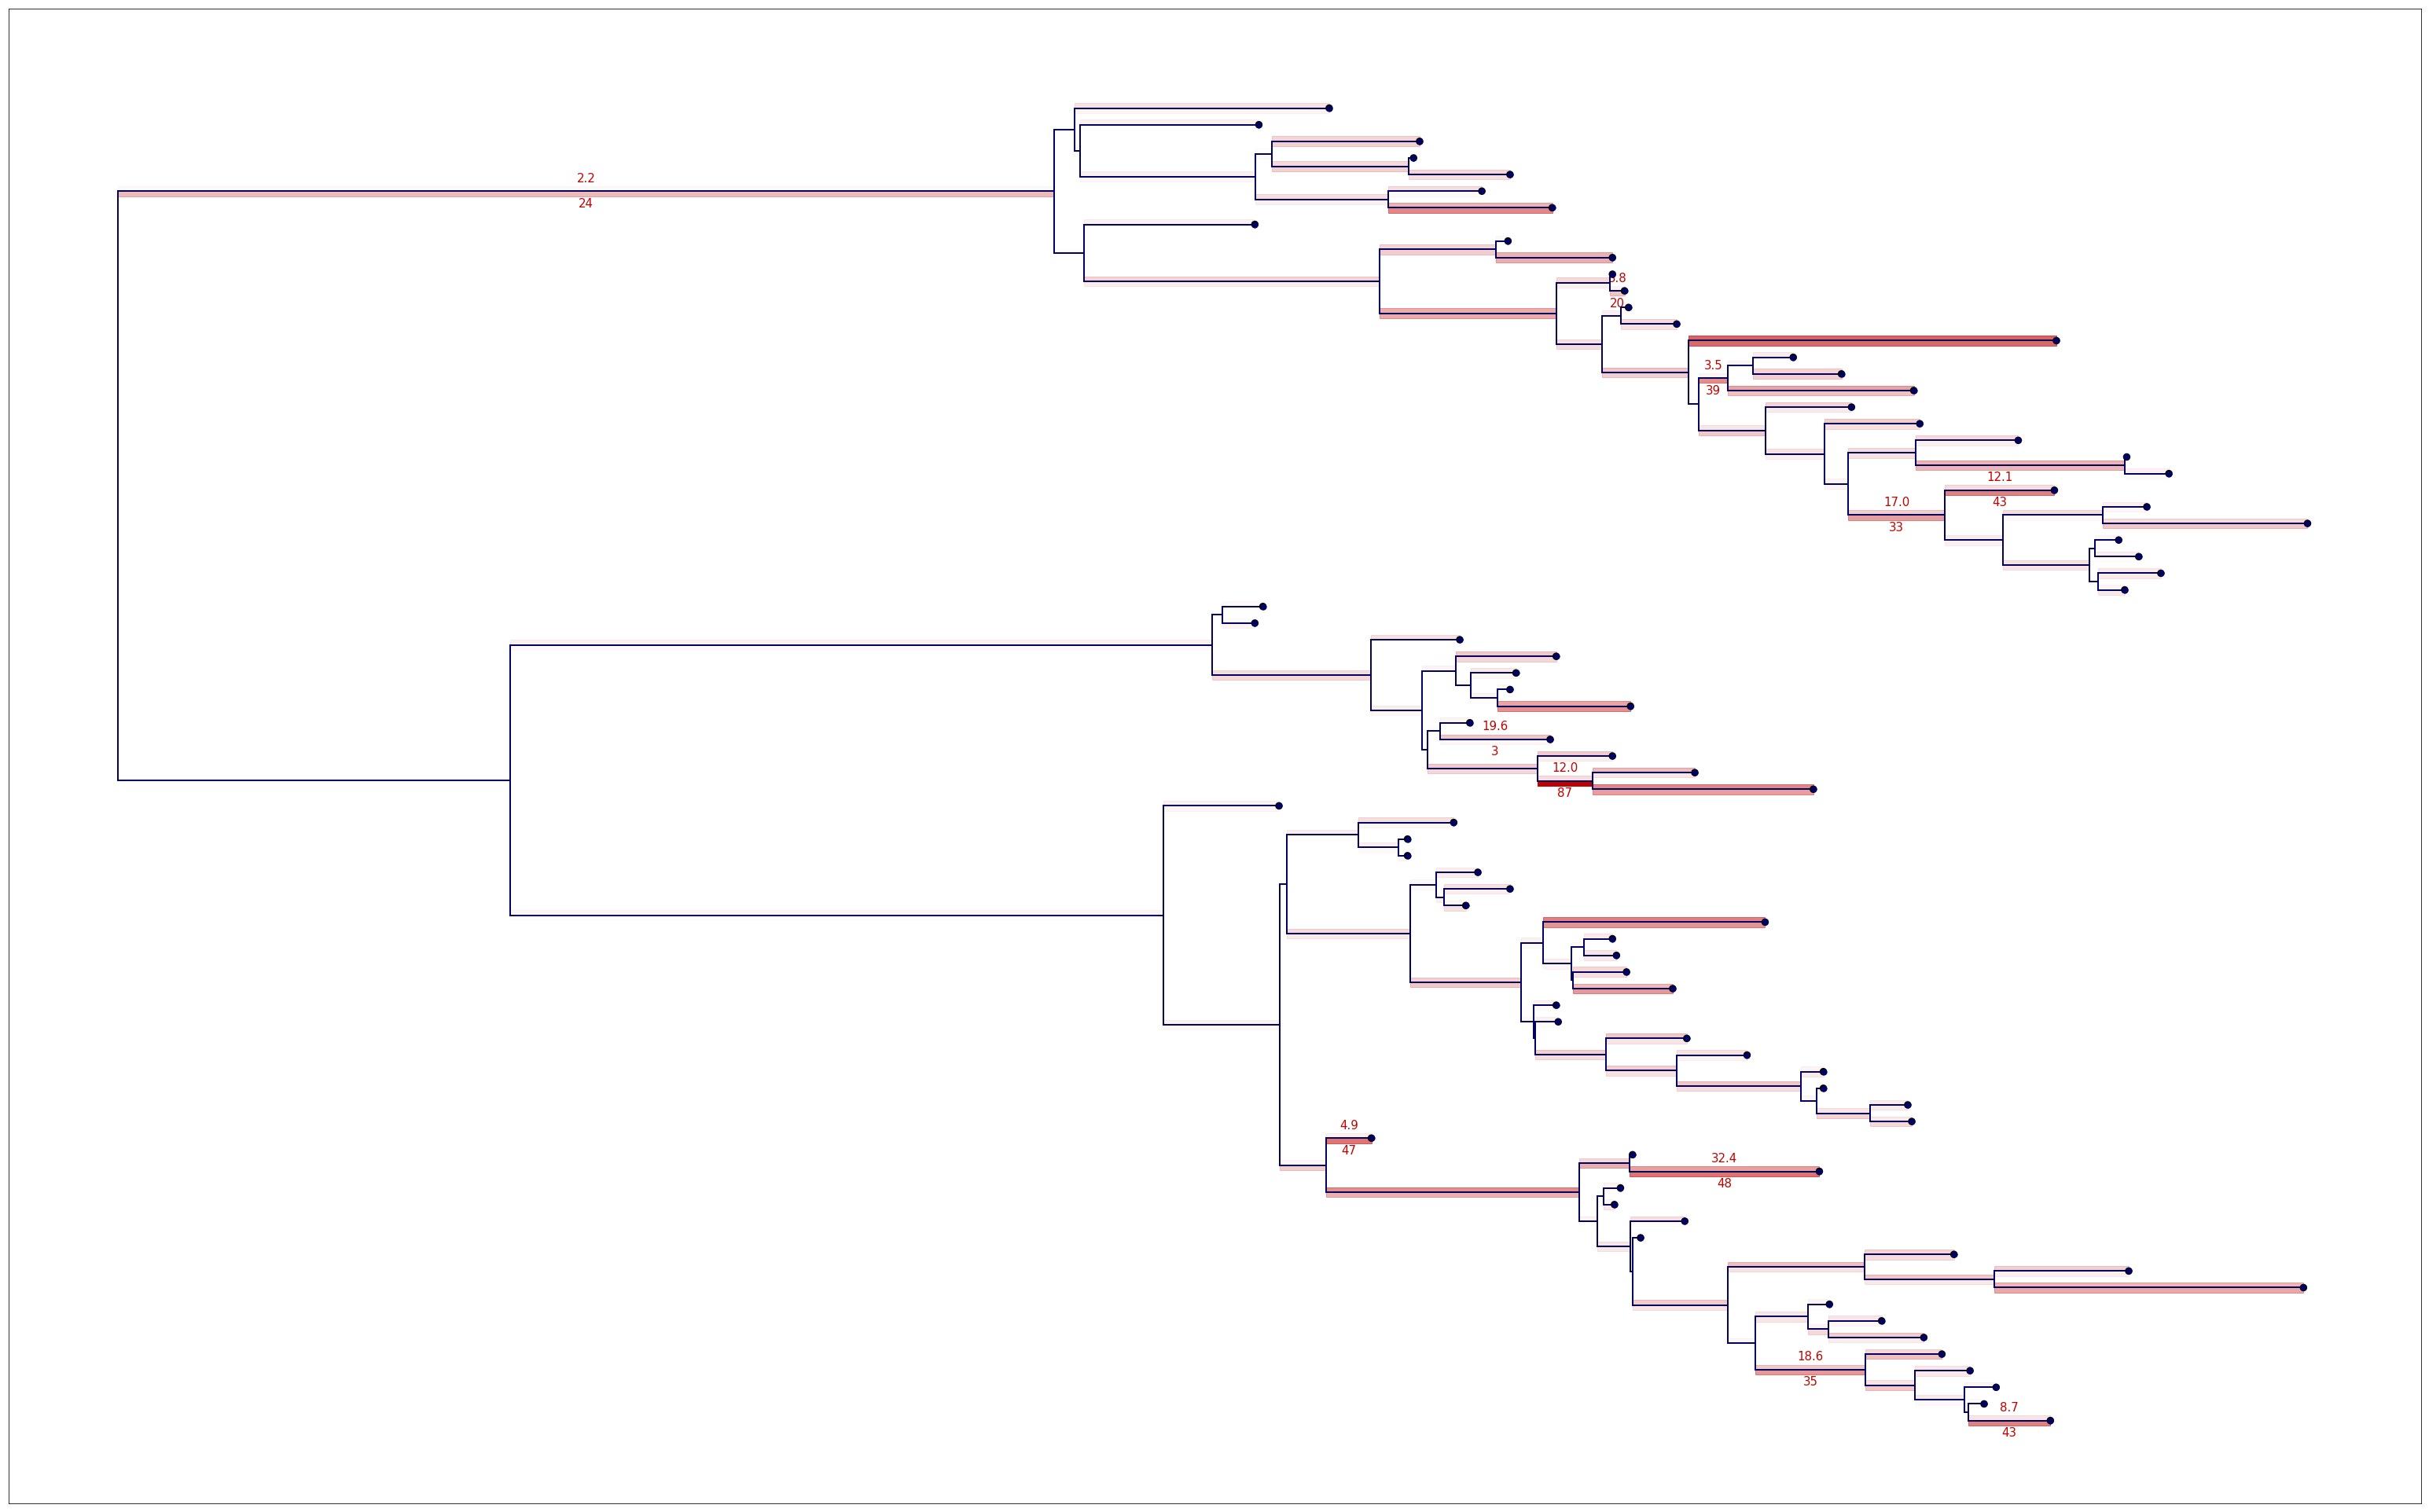

In [10]:
#plotted missing samples distribution
fig,ax = plt.subplots(figsize=(55, 35), facecolor='w')

for index, k in enumerate(pruned_dict.get('pruned_tree').nodes()): ## iterate over objects in tree
    #distribution of missing samples
    if true_num_unsamp.has_key(k.label):
        dropped = true_num_unsamp.get(k.label)
    else:
        dropped = 0
    
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x
        yp = y_pos.get(k)
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
    
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=samp,edgecolor=samp,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=samp,ls=lty,zorder=9) #vertical bar plotting
    ax.plot([xp,x], [y,y], lw=branchWidth, color=samp, ls=lty, zorder=9) #branch plotting
    
    #expected distribution of missing data
    edge_prb = exp[:,index]
    alph = sum(edge_prb) #raw column sum
    ax.add_patch(mpl.patches.Rectangle((xp,y), (x-xp), .3, color = col3, alpha = alph/alpha_scale_factor)) #predicted proportion of dropped
    ax.add_patch(mpl.patches.Rectangle((xp,y-.3), (x-xp), .3, color = col3, alpha = int(dropped)/alpha_scale_factor)) #actual dropped

    #labeling
    if abs(int(dropped) - alph) > .01*len(pruned_dict.get('dropped_samples')): #greater than 1% misclassification ~15 samps
        ax.text(x-1.0/2*(x-xp) , y-.4, dropped, va='top', ha='center', size=15, color = col3) #actual dropped
        ax.text(x-1.0/2*(x-xp) , y+.4, str(round(alph,1)), va='bottom', ha='center', size=15, color = col3) #predicted dropped
ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()

### Plotting Branch Area as a Function of Expected Probability of Attachment to Branch

The branch length is predetermined, but the branch area is determined by the scaled averaged expectation for attachment to a specific branch. Thus, the height of the branch represents the expected amount of attachment/unit of branch length. The label corresponds to the raw difference between observed and expected attachments to a branch (expectation - observations). The color corresponds to the percentile the difference falls under (much greater number of observations than expected is darker red).

In [11]:
diff_dist = [] #distribution of the differences between the expected and observed
for index, k in enumerate(pruned_dict.get('pruned_tree').nodes()):
    edge_prb = exp[:,index] #column from expected at the index of the current edge
    alph = sum(edge_prb) #column sum/number of samples
    dropped = true_num_unsamp.get(k.label)
    diff_dist.append(alph - dropped) #expected - observed 

In [12]:
np.percentile(diff_dist, 50) #white should be at 1.9, the 50th percentile

1.925885713099615

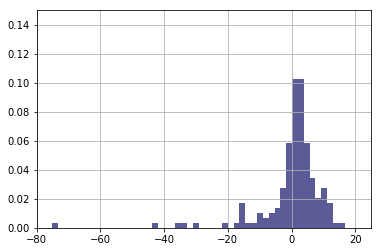

In [13]:
x = diff_dist
# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1, facecolor=samp, alpha=0.65)

plt.axis([-80, 25, 0, 0.15])
plt.grid(True)
plt.show()

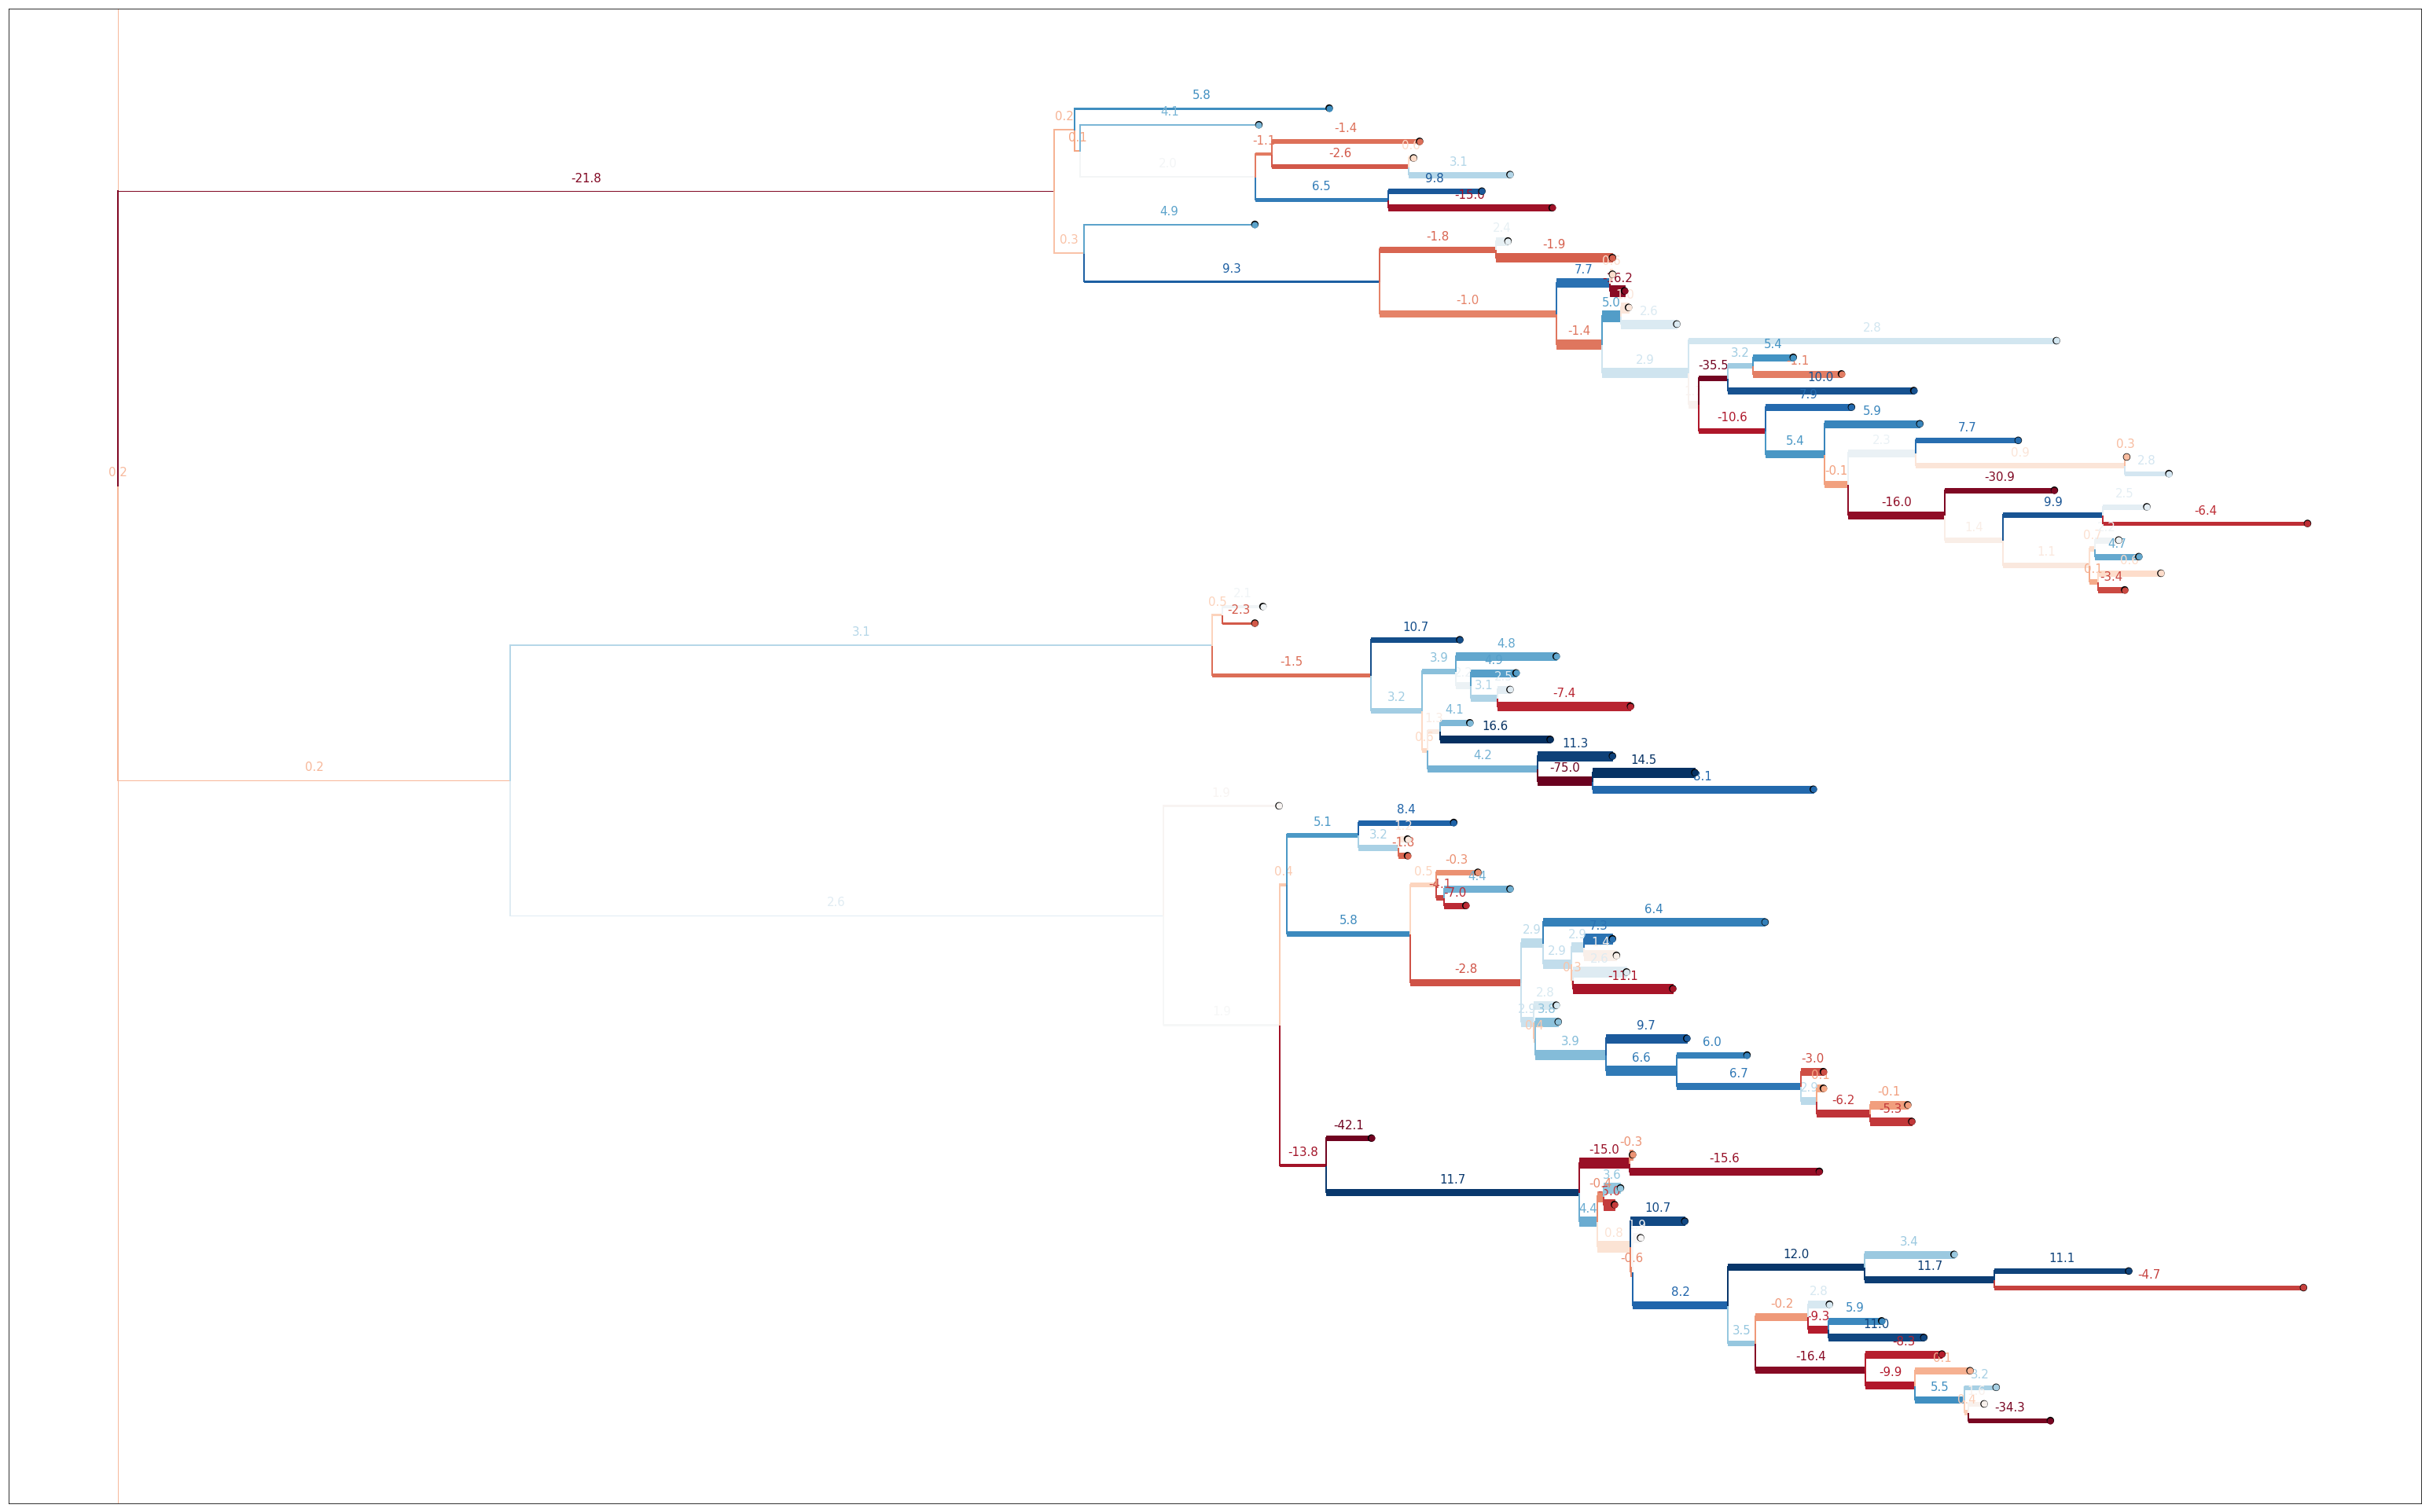

In [14]:
#plotted missing samples distribution
fig,ax = plt.subplots(figsize=(55, 35), facecolor='w')

for index, k in enumerate(pruned_dict.get('pruned_tree').nodes()): ## iterate over objects in tree
    # positioning
    y=y_pos.get(k) 

    if k.parent_node==None:
        x=0.0
        xp=x
        yp = y
    else:
        yp = y_pos.get(k.parent_node)
        xp=k.parent_node.distance_from_root()
        x=k.distance_from_root()
        
    #distribution of missing samples
    if true_num_unsamp.has_key(k.label):
        dropped = true_num_unsamp.get(k.label)
    else:
        dropped = 0
        
    #expected distribution of missing data
    edge_prb = exp[:,index] #column from expected at the index of the current edge
    avg_exp = sum(edge_prb)/len(edge_prb) #column sum/number of samples
    rec_area = avg_exp*5.0
    leng = x-xp
    heig = rec_area/(leng + .000001)

    #color heatmapping
    cmap2 = mpl.cm.get_cmap('RdBu')
    #cs = list(Color(unsamp).range_to(Color(samp),1001))
    percentile = stats.percentileofscore(diff_dist, sum(edge_prb)-dropped)/100.0
    #col_percentile = cs[percentile].hex
        
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=cmap2(percentile), edgecolor=cmap2(percentile), zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k', edgecolor='none', zorder=10) # plot black circle underneath
    ax.plot([xp,xp],[y, yp],lw=branchWidth, color=cmap2(percentile),ls=lty,zorder=9) #vertical bar plotting
    ax.add_patch(mpl.patches.Rectangle((xp,y-.5*heig), (x-xp), heig, color = cmap2(percentile))) #predicted proportion of dropped
    #ax.plot([xp,x], [y,y], lw=branchWidth, color=samp, ls=lty, zorder=9) #branch plotting
    
    #labeling - raw difference between observed and expected (expected - observed), 
    ax.text(x-1.0/2*(x-xp) , y+.4, str(round(avg_exp*len(edge_prb),1)-dropped), va='bottom', ha='center', size=15, color = cmap2(percentile))
ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()

### Proportion of Tips Expected Under Each Internal Node - Remaining Tree

Plots the cumulative proportion of samples expected under each clade and a corresponding color is mapped to this proportion. Darker colors indicate a greater proportion of data expected to fall under that clade. Only internal nodes with greater than .01 proportion of the data are labeled with their respective proportion.

In [15]:
node_probs2 = calculate_cumulative_node_prob(pruned_dict.get('pruned_tree'), 1)

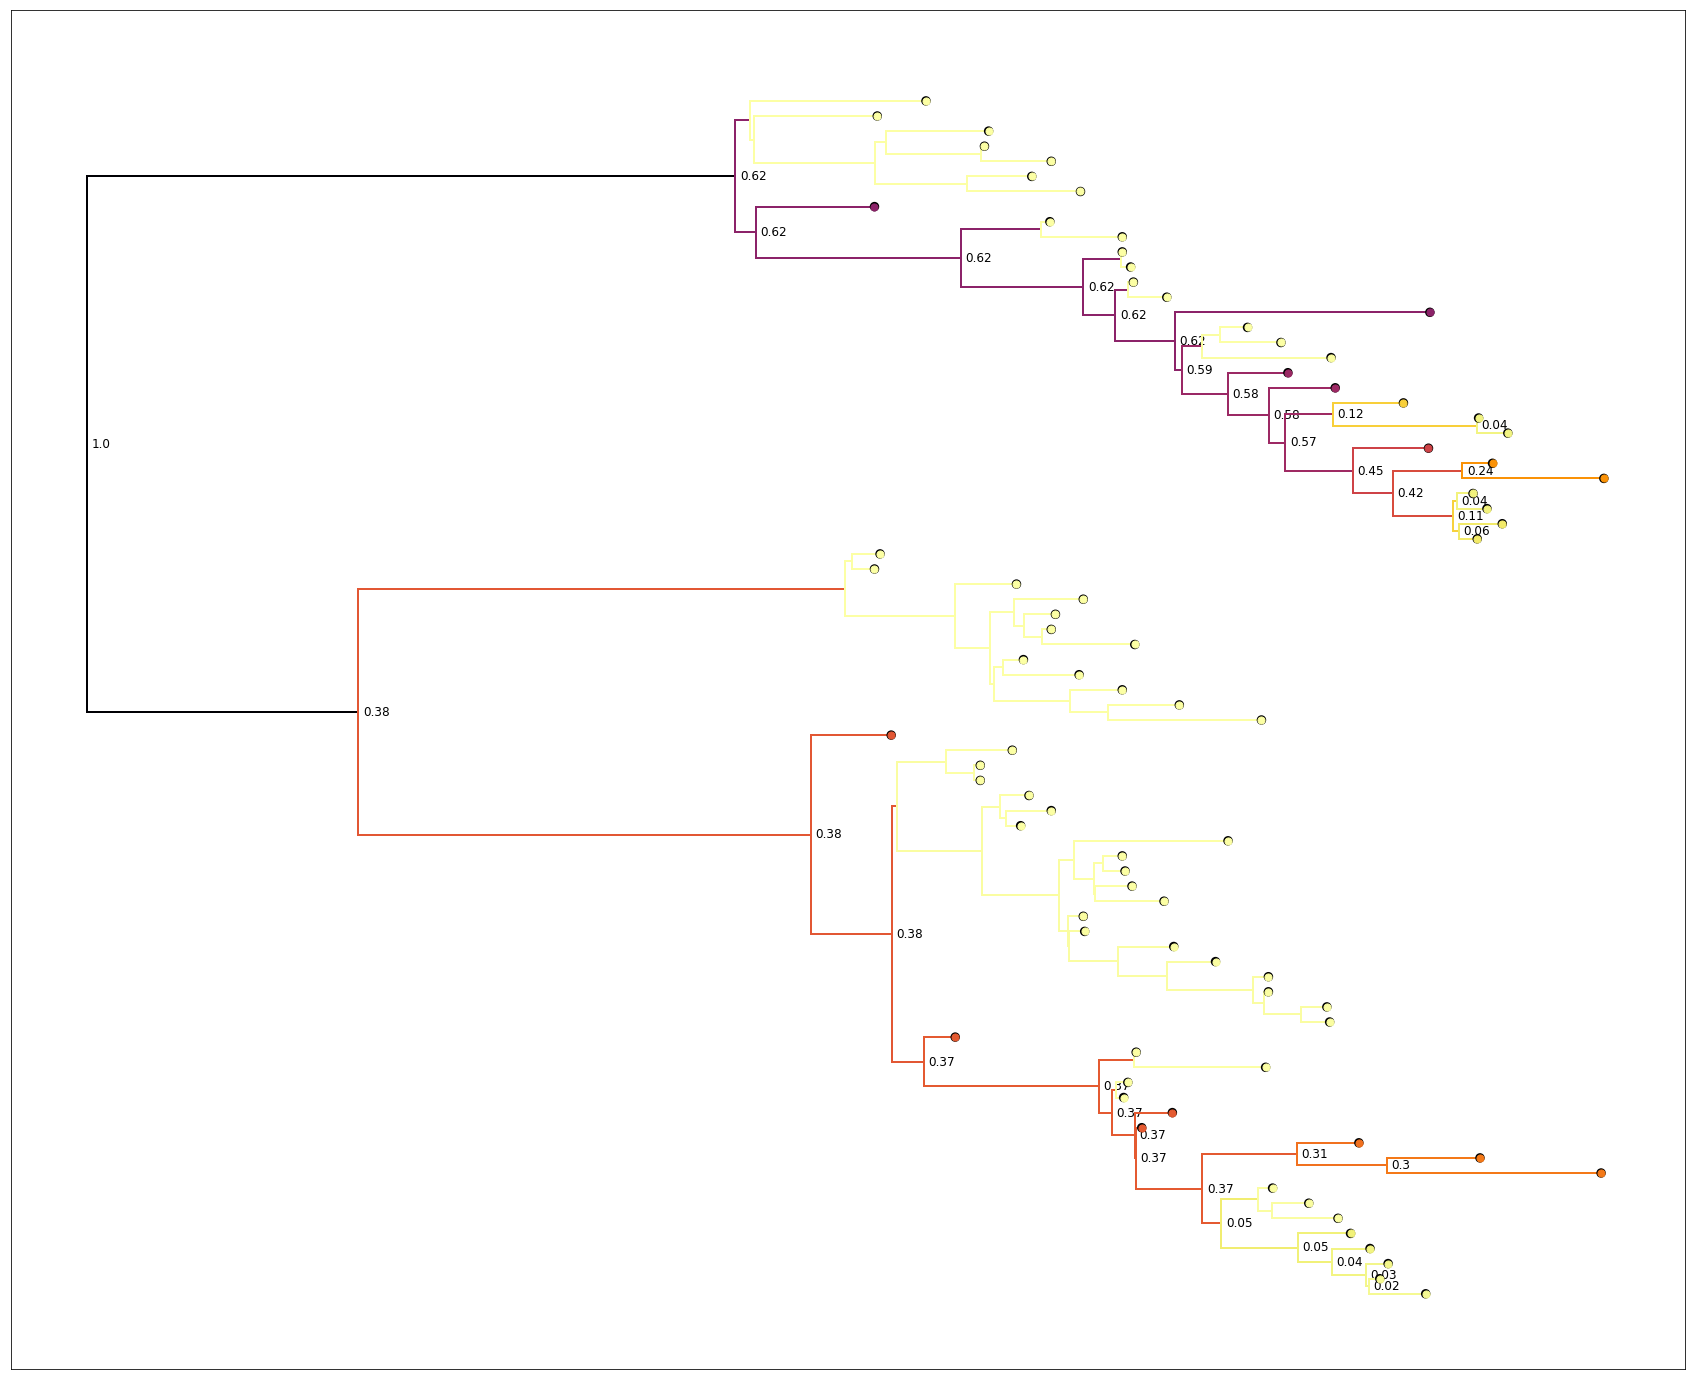

In [16]:
fig,ax = plt.subplots(figsize=(30,25),facecolor='w')

for k in pruned_dict.get('pruned_tree').nodes(): ## iterate over objects in tree
    
    # positioning
    y=y_pos.get(k) 
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()
    
    txt = ""
    # dropped tips, color, lty, size
    if node_probs2.get(k) != None:
        c = cmap(1-(node_probs2.get(k)))
        if node_probs2.get(k) >= .01: #only show the label if its greater than 1% expected prop data
            txt = round(node_probs2.get(k), 2)
    else:
        c = cmap(1-(node_probs2.get(k.parent_node)))

    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
        
    else:
        yc1 = y_pos.get(k.child_nodes()[0])
        yc2 = y_pos.get(k.child_nodes()[-1])
        xc1 = k.child_nodes()[0].distance_from_root()
        xc2 = k.child_nodes()[-1].distance_from_root()
    
        ax.plot([x,x],[yc1, yc2],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xc1,x], [yc1,yc1], lw=branchWidth, color=c, ls=lty, zorder=9) #plot top child edge
        ax.plot([xc2,x], [yc2,yc2], lw=branchWidth, color=c, ls=lty, zorder=9) #plot bottom child edge
    
    #labeling
    ax.text(x + .009, y, txt, va = 'center', ha= 'left', size=12, color = 'k')

ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()

### Z-Scores of Pruned Tree

In [17]:
zs2 = node_zscores(node_probs2, pruned_dict.get('pruned_tree'))

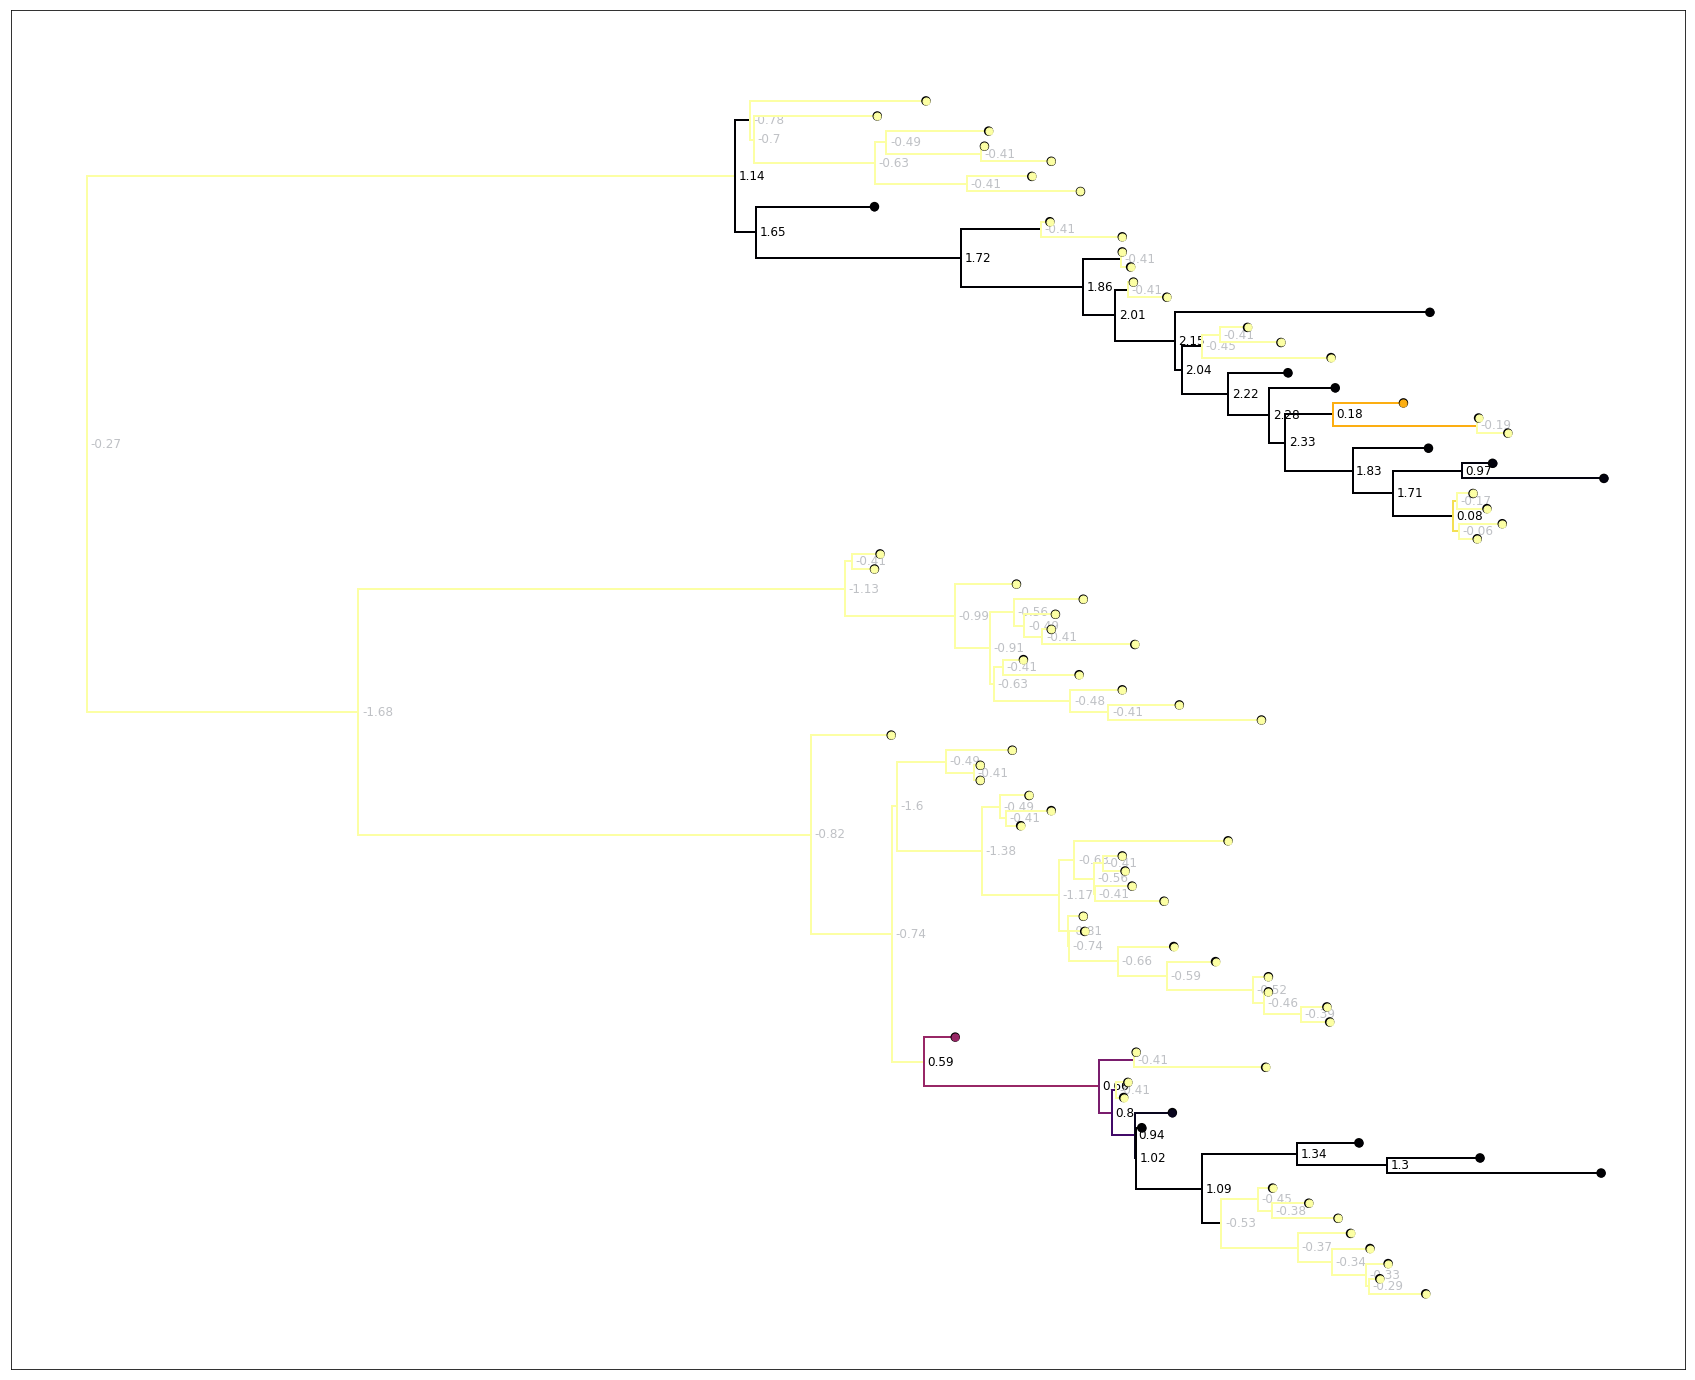

In [18]:
fig,ax = plt.subplots(figsize=(30,25),facecolor='w')

for k in pruned_dict.get('pruned_tree').nodes(): ## iterate over objects in tree
    
    # positioning
    y=y_pos.get(k) 
    if k.edge.rootedge:
        x=0.0
    else:
        x=k.distance_from_root()

    # tree color, label color
    if node_probs2.get(k) != None:
        c = cmap(1-(zs2.get(k)))
        txt = round(zs2.get(k), 2)
        
        if zs2.get(k) > 0:
            txt_c = "k"
        else:
            txt_c = '#bfc1c5'
    else:
        c = cmap(1-(zs2.get(k.parent_node)))
        txt = ""
        
    #plotting
    if k.is_leaf(): # if leaf...
        ax.scatter(x,y,s=s,facecolor=c,edgecolor=c,zorder=11) # plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) # plot black circle underneath
        
    else:
        yc1 = y_pos.get(k.child_nodes()[0])
        yc2 = y_pos.get(k.child_nodes()[-1])
        xc1 = k.child_nodes()[0].distance_from_root()
        xc2 = k.child_nodes()[-1].distance_from_root()
    
        ax.plot([x,x],[yc1, yc2],lw=branchWidth, color=c,ls=lty,zorder=9) #vertical bar plotting
        ax.plot([xc1,x], [yc1,yc1], lw=branchWidth, color=c, ls=lty, zorder=9) #plot top child edge
        ax.plot([xc2,x], [yc2,yc2], lw=branchWidth, color=c, ls=lty, zorder=9) #plot bottom child edge
    
    #labeling
    ax.text(x + .007, y, txt, va = 'center', ha= 'left', size=12, color = txt_c)

ax.set_ylim(-5, y_ax + 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

### Node Impurity: Categorical Cross-Entropy

Categorical cross entropy is used to measure classification error as compared to a null model. It can be defined as:
$$H(p,q) = - \sum_{i=0}^k p_i \cdot log(q_i)$$
where $p$ corresponds to the one hot encoding of our known, observed probability distribution (in our case each sample attaches at exactly one place and so the row will have 0s and one 1 at the index corresponding to the branch). $q$ is the expected distribution calculated across the $k$ categories.

Entropy is minimized and we seek to outperform the null which was created by giving each possible edge an equal probability of attachment.

In [19]:
total_entropy = 0

for row_o, row_e in zip(obs, exp):
    p_mk = list(row_e)[list(row_o).index(1.0)]
    ent =  math.log(p_mk)
    total_entropy += -1*ent
print "total entropy:", total_entropy

total entropy: 5231.07783374


In [20]:
average_entropy = total_entropy/obs.shape[0] #avg entropy
print "average sample entropy:",  average_entropy

average sample entropy: 3.41900512009


In [21]:
null_entropy = -1*math.log(1.0/(obs.shape[1]))*obs.shape[0]
print "null model entropy:", null_entropy

null model entropy: 7755.4234294


In [22]:
single_sample_null_entropy = null_entropy/obs.shape[0]
print "entropy of a single sample created under the null:",  single_sample_null_entropy

entropy of a single sample created under the null: 5.06890420222


### Variance of Expected Data Distribution

Resampling: for each run, resample $n$ = number of dropped samples, the value generated represents the index of attachment where each $n_i$ is sampled from the discrete distribution of its respective expectation calculated under the coalescent. The result of each run is a list with length equal to the number of possible edges to attach to and each value within the list corresponding to the summed total number of samples that series of random draws predicts 

In [23]:
num_runs = 100
edg = len(pruned_dict.get('pruned_tree').edges())
full_counts = np.zeros((num_runs, edg))
rd.seed(10)

for run in range(num_runs):
    for row in exp:
        distr = stats.rv_discrete(values = (range(len(row)), list(row)))
        rv = distr.rvs(size=1)
        full_counts[run][int(rv)] += 1

For each edge, calculates the middle 95 percentiles (2.5th - 97.5th percentile)

In [24]:
#grab the middle 95 percentiles of data for each branch
pct_025 = np.percentile(full_counts, 2.5, axis = 0)
pct_975 = np.percentile(full_counts, 97.5, axis=0)

### Observed versus Expected Sum Attachments

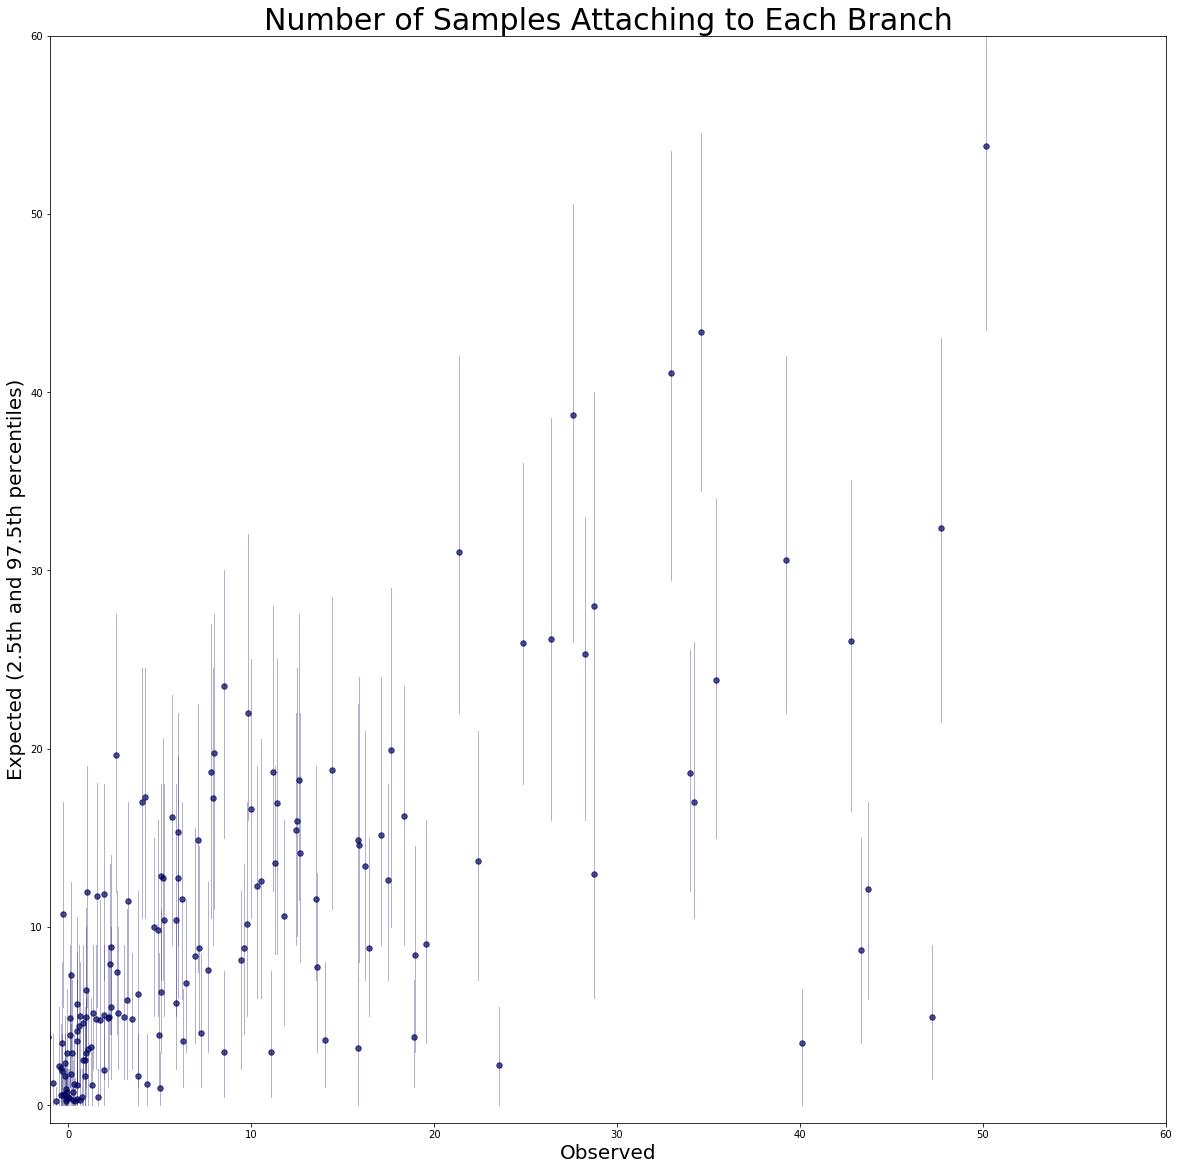

In [25]:
#the summed number of dropped observations expected to fall on each edge (with 2.5th and 97.5th percentiles)
#plotted against that actual observed number of dropped samples attached to each branch
exp_sum_att = list(sum(exp)) #column sums
obs_sum_att = list(sum(obs)) #column sums

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

obs_sum_att = rand_jitter(obs_sum_att)

fig,ax = plt.subplots(figsize=(20,20),facecolor='w')
for cur_exp, cur_obs, lb, ub in zip(exp_sum_att, obs_sum_att, pct_025, pct_975):
    if lb < cur_exp and cur_exp < ub:
        c = samp
        orde = 10
    else:
        c= col4
        orde = 20
    ax.scatter(cur_obs,cur_exp,s=30,facecolor=c,edgecolor=c, alpha = .7, zorder = orde)
    ax.plot([cur_obs,cur_obs],[lb, ub],lw=1, color=c,ls='-', alpha = .3, zorder = orde) 

ax.set_title('Number of Samples Attaching to Each Branch', fontsize = 30)
ax.set_xlabel('Observed', fontsize = 20)
ax.set_ylabel('Expected (2.5th and 97.5th percentiles)', fontsize = 20)
ax.set_ylim(-1, 60) 
ax.set_xlim(-1, 60) 
plt.show()

In [26]:
pearsonr(exp_sum_att, obs_sum_att)

(0.61942405016953583, 3.2098035842180325e-18)